In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Linear")

/tmp/ipykernel_236972/2073897847.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


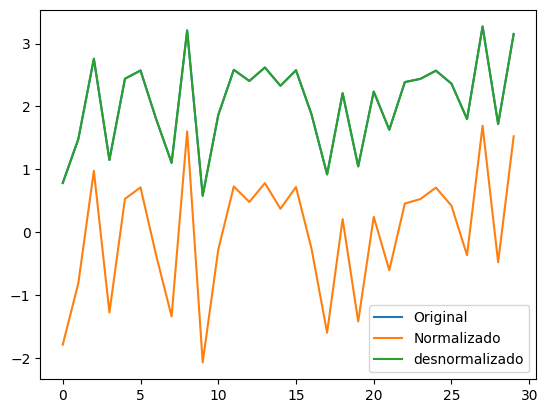

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-02 18:53:04.176753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 18:53:04.176808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 18:53:04.178079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 18:53:04.184998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-02 18:53:05.165045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_8,0.206992,0.128498,0.147097,-0.080219,0.106709,0.517361,0.597476,0.096334,0.116789,0.326663,-0.866873,0.329567,134.475303,312.328202
model_1_0_9,0.216827,0.114267,0.172296,-0.068215,0.105385,0.525809,0.579824,0.095263,0.115333,0.324631,-0.843719,0.327517,134.500263,312.353162
model_1_0_6,0.100328,0.102124,0.036532,-0.279833,0.121062,0.533018,0.674929,0.114136,0.127729,0.347939,-1.117977,0.351032,134.222910,312.075809
model_1_0_7,0.129618,0.099199,0.100593,-0.111546,0.117120,0.534754,0.630053,0.099128,0.118683,0.342229,-1.049024,0.345271,134.289105,312.142005
model_1_0_5,0.102167,0.072813,-0.000225,-0.226041,0.120814,0.550418,0.700678,0.109338,0.127821,0.347583,-1.113648,0.350673,134.227002,312.079901
model_1_0_4,0.096855,0.063164,-0.011191,-0.226173,0.121529,0.556147,0.708360,0.109350,0.127077,0.348610,-1.126155,0.351709,134.215202,312.068101
model_1_0_3,0.093996,0.055504,-0.019944,-0.219994,0.121914,0.560694,0.714492,0.108799,0.126335,0.349162,-1.132885,0.352265,134.208882,312.061781
model_1_0_2,0.066533,0.048553,0.033309,-0.146164,0.125609,0.564820,0.677187,0.102215,0.134594,0.354414,-1.197536,0.357564,134.149159,312.002058
model_1_0_0,0.032418,0.036616,0.041633,-0.165156,0.130200,0.571907,0.671356,0.103909,0.140057,0.360832,-1.277849,0.364040,134.077369,311.930268
model_1_0_1,0.048503,0.036351,0.031903,-0.067593,0.128035,0.572064,0.678172,0.095208,0.138828,0.357820,-1.239983,0.361001,134.110896,311.963795


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_5,0.390084,0.182737,0.254610,0.069537,0.082072,0.485163,0.522161,0.122198,0.104417,0.286481,-0.435844,0.289028,135.000327,312.853226
model_1_1_2,0.302491,0.173830,0.223448,0.147953,0.093858,0.490450,0.543991,0.111899,0.110939,0.306363,-0.642052,0.309086,134.731940,312.584839
model_1_1_3,0.297479,0.171611,0.213038,0.112951,0.094533,0.491768,0.551283,0.116496,0.111553,0.307462,-0.653851,0.310195,134.717620,312.570519
model_1_1_4,0.350519,0.168664,0.246279,0.115979,0.087396,0.493517,0.527997,0.116098,0.107542,0.295627,-0.528986,0.298255,134.874623,312.727522
model_1_1_6,0.390002,0.149791,0.242560,-0.050544,0.082083,0.504721,0.530603,0.137968,0.104173,0.286501,-0.436036,0.289047,135.000059,312.852958
model_1_1_1,0.238500,0.135806,0.183172,0.188983,0.102469,0.513023,0.572205,0.106511,0.113594,0.320108,-0.792697,0.322953,134.556390,312.409289
model_1_1_0,0.219309,0.117440,0.179619,0.204068,0.105051,0.523926,0.574694,0.104530,0.114571,0.324116,-0.837878,0.326998,134.506610,312.359509
model_1_1_7,0.466880,0.071387,0.245768,0.024294,0.071738,0.551265,0.528355,0.128139,0.103180,0.267839,-0.255053,0.270220,135.269477,313.122376
model_1_1_8,0.485685,-0.037476,0.249525,0.031504,0.069207,0.615891,0.525724,0.127192,0.101030,0.263073,-0.210782,0.265411,135.341299,313.194198
model_1_1_9,0.487633,-0.141830,0.254815,-0.029693,0.068945,0.677839,0.522018,0.135229,0.099111,0.262574,-0.206198,0.264908,135.348886,313.201786


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_8,0.508878,0.056137,0.166938,0.299165,0.066086,0.560318,0.583577,0.201910,0.096031,0.257073,-0.156183,0.259358,135.433584,313.286483
model_1_2_9,0.469094,0.054693,0.140073,0.174424,0.071440,0.561175,0.602396,0.237848,0.099566,0.267282,-0.249841,0.269658,135.277800,313.130699
model_1_2_7,0.519352,0.015552,0.192813,0.364663,0.064677,0.584411,0.565451,0.183040,0.096370,0.254317,-0.131526,0.256577,135.476698,313.329597
model_1_2_0,0.517184,-0.191205,0.263670,0.632825,0.064969,0.707151,0.515814,0.105783,0.096457,0.254890,-0.136628,0.257155,135.467700,313.320599
model_1_2_1,0.515380,-0.224012,0.261079,0.622579,0.065212,0.726626,0.517630,0.108735,0.096866,0.255365,-0.140877,0.257635,135.460238,313.313137
model_1_2_2,0.511327,-0.256982,0.260282,0.607247,0.065757,0.746199,0.518188,0.113152,0.097411,0.256431,-0.150418,0.258710,135.443583,313.296482
model_1_2_4,0.497807,-0.262010,0.225342,0.545675,0.067576,0.749184,0.542664,0.130891,0.098267,0.259954,-0.182247,0.262265,135.389000,313.241899
model_1_2_3,0.495125,-0.269228,0.231459,0.552625,0.067937,0.753468,0.538379,0.128888,0.098431,0.260647,-0.188561,0.262964,135.378346,313.231245
model_1_2_5,0.504725,-0.559255,0.058804,0.528539,0.066645,0.925641,0.659327,0.135827,0.098461,0.258157,-0.165961,0.260452,135.416742,313.269641
model_1_2_6,0.507010,-0.612616,-0.018410,0.531532,0.066338,0.957318,0.713418,0.134965,0.097263,0.257561,-0.160581,0.259851,135.425991,313.278890


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.412880,0.121618,0.251775,-0.642160,0.079004,0.521445,0.524147,0.125324,0.091758,0.281077,-0.382179,0.283575,135.076510,312.929409
model_1_3_1,0.393253,0.106741,0.244839,-1.070853,0.081645,0.530277,0.529006,0.158040,0.091250,0.285736,-0.428383,0.288276,135.010746,312.863645
model_1_3_2,0.358782,0.072767,0.216866,-1.684191,0.086284,0.550446,0.548601,0.204848,0.091863,0.293741,-0.509533,0.296352,134.900232,312.753131
model_1_3_3,0.380505,0.070445,0.229372,-1.518746,0.083361,0.551824,0.539841,0.192222,0.091684,0.288722,-0.458395,0.291289,134.969160,312.822059
model_1_3_4,0.366118,0.058241,0.220231,-1.691950,0.085297,0.559069,0.546245,0.205440,0.092012,0.292056,-0.492264,0.294652,134.923244,312.776143
model_1_3_5,0.298283,-0.010242,0.171133,-2.511061,0.094424,0.599723,0.580638,0.267952,0.091782,0.307286,-0.651958,0.310017,134.719910,312.572809
model_1_3_6,0.067113,-0.148647,-0.095916,-4.802635,0.125531,0.681887,0.767712,0.442837,0.097904,0.354304,-1.196172,0.357453,134.150401,312.003301
model_1_3_8,-0.187688,-0.304324,-0.369060,-7.225300,0.159818,0.774303,0.959055,0.627726,0.101977,0.399772,-1.796016,0.403326,133.667442,311.520341
model_1_3_7,-0.208781,-0.314448,-0.396825,-7.336340,0.162656,0.780313,0.978505,0.636200,0.103902,0.403306,-1.845672,0.406891,133.632234,311.485133
model_1_3_9,-0.196818,-0.321264,-0.347272,-7.340283,0.161046,0.784359,0.943792,0.636501,0.101706,0.401306,-1.817509,0.404873,133.652127,311.505026


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,-0.180167,-0.310424,-0.367181,0.372702,0.158806,0.777924,0.957739,0.116073,0.101109,0.398504,-1.778311,0.402047,133.680146,311.533045
model_1_4_2,-0.040474,-0.318460,0.024361,0.133293,0.140008,0.782695,0.683455,0.160372,0.110554,0.374177,-1.449450,0.377503,133.932106,311.785005
model_1_4_4,-0.125881,-0.464302,0.046583,-0.671366,0.151501,0.869273,0.667888,0.309263,0.107490,0.389231,-1.650510,0.392691,133.774328,311.627227
model_1_4_1,-0.259366,-0.469966,-0.156608,0.084124,0.169463,0.872635,0.810228,0.169470,0.121517,0.411659,-1.964757,0.415318,133.550242,311.403141
model_1_4_6,-0.498092,-0.485984,0.070044,-2.871559,0.201586,0.882145,0.651453,0.716377,0.124977,0.448984,-2.526759,0.452975,133.203074,311.055973
model_1_4_3,-0.014239,-0.487010,0.088455,-0.013352,0.136478,0.882753,0.638556,0.187506,0.104133,0.369430,-1.387689,0.372713,133.983181,311.836080
model_1_4_5,-0.156415,-0.492471,0.048910,-0.877894,0.155610,0.885996,0.666258,0.347478,0.111202,0.394474,-1.722394,0.397980,133.720809,311.573708
model_1_4_7,-0.925759,-0.558436,0.048163,-4.805190,0.259134,0.925155,0.666782,1.074168,0.124649,0.509052,-3.533558,0.513577,132.700819,310.553718
model_1_4_8,-1.120931,-0.814742,0.043118,-5.741993,0.285397,1.077309,0.670316,1.247510,0.122147,0.534226,-3.993025,0.538974,132.507749,310.360648
model_1_4_9,-1.070060,-0.844826,0.039750,-5.574752,0.278552,1.095168,0.672675,1.216564,0.121128,0.527780,-3.873265,0.532471,132.556304,310.409203


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_2,-0.103355,-0.035149,0.269099,-0.371422,0.148470,0.614509,0.512011,0.232231,0.134076,0.385318,-1.597482,0.388743,133.814747,311.667646
model_1_5_3,-0.183762,-0.064428,0.266999,-0.710652,0.159289,0.631890,0.513482,0.289674,0.134838,0.399111,-1.786772,0.402659,133.674065,311.526964
model_1_5_5,-0.004472,-0.070821,0.231713,-1.362511,0.135164,0.635685,0.538201,0.400057,0.116648,0.367646,-1.364695,0.370914,134.002535,311.855434
model_1_5_6,0.181352,-0.077479,0.205150,-0.851352,0.110159,0.639638,0.556809,0.313500,0.108198,0.331902,-0.927233,0.334852,134.411662,312.264561
model_1_5_8,0.468487,-0.085995,0.144364,-0.016677,0.071521,0.644694,0.599391,0.172160,0.094691,0.267435,-0.251269,0.269812,135.275516,313.128415
model_1_5_7,0.330306,-0.102190,0.162569,-0.447534,0.090115,0.654308,0.586638,0.245119,0.100448,0.300192,-0.576572,0.302861,134.813327,312.666226
model_1_5_4,-0.199390,-0.109643,0.241706,-1.869682,0.161392,0.658732,0.531201,0.485939,0.125620,0.401737,-1.823563,0.405308,133.647833,311.500732
model_1_5_9,0.576339,-0.112070,0.023478,0.212478,0.057009,0.660173,0.684074,0.133356,0.084566,0.238765,0.002631,0.240887,135.729102,313.582001
model_1_5_1,-0.407946,-0.184999,0.147636,0.585796,0.189456,0.703466,0.597099,0.070140,0.122237,0.435266,-2.314539,0.439135,133.327195,311.180094
model_1_5_0,-0.704974,-0.540566,0.159126,0.418455,0.229425,0.914546,0.589050,0.098476,0.131823,0.478983,-3.013793,0.483241,132.944359,310.797258


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++

Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_5,0.694230,0.002881,0.197950,0.617281,0.041145,0.591933,0.561853,0.064290,0.072207,0.202842,0.280167,0.204645,136.381304,314.234203
model_1_6_4,0.676032,0.001772,0.186674,0.669763,0.043594,0.592591,0.569752,0.055474,0.075982,0.208791,0.237326,0.210647,136.265682,314.118582
model_1_6_2,0.660504,-0.007447,0.201251,0.790601,0.045683,0.598064,0.559540,0.035175,0.074303,0.213736,0.200770,0.215636,136.172046,314.024945
model_1_6_3,0.674147,-0.015129,0.197024,0.781118,0.043847,0.602624,0.562501,0.036768,0.072594,0.209398,0.232887,0.211259,136.254076,314.106975
model_1_6_6,0.678526,-0.047093,0.181796,0.417083,0.043258,0.621600,0.573169,0.097920,0.071685,0.207986,0.243196,0.209835,136.281135,314.134034
model_1_6_1,0.633283,-0.058262,0.184589,0.748419,0.049346,0.628230,0.571213,0.042261,0.077158,0.222140,0.136687,0.224115,136.017789,313.870689
model_1_6_9,0.642128,-0.062328,0.152255,0.139897,0.048156,0.630644,0.593863,0.144482,0.070550,0.219445,0.157511,0.221395,136.066621,313.919520
model_1_6_0,0.641603,-0.066276,0.167550,0.788788,0.048227,0.632987,0.583148,0.035480,0.076937,0.219606,0.156275,0.221558,136.063689,313.916589
model_1_6_8,0.611955,-0.067978,0.125517,0.053886,0.052216,0.633998,0.612594,0.158930,0.072334,0.228509,0.086478,0.230540,135.904727,313.757627
model_1_6_7,0.658273,-0.074259,0.147762,0.282709,0.045983,0.637726,0.597011,0.120492,0.072630,0.214438,0.195519,0.216344,136.158948,314.011847


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.652168,-0.058285,0.162747,0.836880,0.046805,0.628244,0.586513,0.023101,0.071040,0.216345,0.181145,0.218268,136.123529,313.976428
model_1_7_1,0.651427,-0.058436,0.167689,0.779020,0.046905,0.628333,0.583051,0.031295,0.074335,0.216575,0.179402,0.218500,136.119276,313.972176
model_1_7_2,0.171326,-0.113314,0.186316,-1.702871,0.111508,0.660911,0.570002,0.382773,0.109996,0.333928,-0.950837,0.336897,134.387316,312.240215
model_1_7_3,-0.138376,-0.138789,0.181112,-3.259353,0.153182,0.676034,0.573648,0.603198,0.120619,0.391385,-1.679928,0.394864,133.752253,311.605152
model_1_7_4,-0.747970,-0.215488,0.173768,-6.246582,0.235211,0.721566,0.578793,1.026240,0.137136,0.484985,-3.115014,0.489296,132.894548,310.747447
model_1_7_5,-0.873677,-0.222831,0.172940,-6.851663,0.252126,0.725925,0.579373,1.111930,0.140069,0.502121,-3.410947,0.506585,132.755654,310.608553
model_1_7_6,-1.422913,-0.264518,0.117689,-9.554988,0.326032,0.750673,0.618077,1.494768,0.150481,0.570992,-4.703942,0.576068,132.241518,310.094417
model_1_7_7,-1.385748,-0.272981,0.107658,-9.395061,0.321031,0.755697,0.625104,1.472119,0.149300,0.566596,-4.616449,0.571633,132.272433,310.125332
model_1_7_8,-1.356314,-0.290404,0.096591,-9.277585,0.317071,0.766040,0.632857,1.455483,0.148495,0.563090,-4.547156,0.568096,132.297262,310.150161
model_1_7_9,-1.749868,-0.335792,0.083304,-11.138934,0.370028,0.792984,0.642165,1.719082,0.156035,0.608299,-5.473649,0.613707,131.988353,309.841252


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++

Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,-1.653801,-0.346772,0.077835,0.881328,0.357101,0.799502,0.645995,0.017359,0.154157,0.597579,-5.247491,0.602891,132.059473,309.912372
model_1_8_1,-1.500468,-0.381641,0.084748,0.737229,0.336468,0.820202,0.641153,0.038438,0.155245,0.580059,-4.886519,0.585215,132.178503,310.031402
model_1_8_5,-1.295510,-0.382682,0.087412,0.765501,0.308889,0.820820,0.639287,0.034302,0.151022,0.555777,-4.404012,0.560718,132.349549,310.202448
model_1_8_4,-1.336173,-0.387545,0.083851,0.781786,0.314360,0.823707,0.641781,0.031920,0.151502,0.560678,-4.499741,0.565662,132.314431,310.167330
model_1_8_3,-1.454936,-0.394952,0.085905,0.730959,0.330341,0.828104,0.640343,0.039355,0.155116,0.574753,-4.779329,0.579862,132.215257,310.068156
model_1_8_2,-1.495423,-0.396683,0.089465,0.730878,0.335789,0.829131,0.637849,0.039367,0.155897,0.579473,-4.874641,0.584624,132.182543,310.035442
model_1_8_6,-0.492529,-0.496325,0.041248,0.715162,0.200838,0.888283,0.671626,0.041666,0.138561,0.448149,-2.513663,0.452133,133.210514,311.063414
model_1_8_7,-0.483120,-0.522741,0.021597,0.749820,0.199572,0.903965,0.685392,0.036596,0.136931,0.446735,-2.491512,0.450706,133.223163,311.076062
model_1_8_8,-0.454717,-0.533033,0.021425,0.756841,0.195750,0.910074,0.685512,0.035569,0.135827,0.442436,-2.424646,0.446369,133.261836,311.114736
model_1_8_9,-0.298158,-0.553606,0.024782,0.754932,0.174683,0.922287,0.683161,0.035848,0.129766,0.417951,-2.056079,0.421666,133.489567,311.342466


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.477067,-0.500407,-0.021105,-0.458088,0.070367,0.890707,0.715306,0.114051,0.097298,0.265268,-0.231072,0.267626,135.308062,313.160962
model_1_9_0,0.071614,-0.502049,0.023403,0.386731,0.124926,0.891681,0.684127,0.047970,0.118491,0.353448,-1.185575,0.356590,134.160074,312.012973
model_1_9_7,0.351228,-0.504771,0.006742,-0.061852,0.087300,0.893297,0.695798,0.083058,0.104018,0.295466,-0.527318,0.298092,134.876806,312.729705
model_1_9_8,0.362011,-0.505296,0.010483,-0.128222,0.085849,0.893609,0.693177,0.088249,0.103536,0.293000,-0.501932,0.295605,134.910328,312.763227
model_1_9_2,0.206867,-0.526486,0.018753,0.091101,0.106726,0.906188,0.687384,0.071094,0.113240,0.326689,-0.867168,0.329593,134.474987,312.327887
model_1_9_6,0.259996,-0.548317,-0.027906,0.119258,0.099577,0.919148,0.720070,0.068891,0.110246,0.315558,-0.742094,0.318363,134.613657,312.466556
model_1_9_1,0.201282,-0.548508,-0.054901,0.194538,0.107477,0.919262,0.738980,0.063003,0.113278,0.327837,-0.880315,0.330751,134.460954,312.313853
model_1_9_5,0.249916,-0.556977,-0.013503,0.109023,0.100933,0.924289,0.709980,0.069692,0.111177,0.317699,-0.765824,0.320523,134.586598,312.439497
model_1_9_4,0.223579,-0.562704,-0.026632,0.107163,0.104477,0.927688,0.719177,0.069837,0.112848,0.323229,-0.827824,0.326102,134.517581,312.370480
model_1_9_3,0.210148,-0.567220,-0.018000,0.103123,0.106284,0.930370,0.713130,0.070153,0.113472,0.326013,-0.859444,0.328910,134.483278,312.336177


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.561964,-0.744525,-0.049593,0.370268,0.058943,1.035626,0.735262,0.114128,0.093598,0.242782,-0.031209,0.244940,135.662368,313.515268
model_1_10_1,0.680588,-0.880322,-0.056065,0.756842,0.042981,1.116241,0.739795,0.044068,0.078083,0.207318,0.248052,0.209161,136.294008,314.146907
model_1_10_2,0.680466,-1.013094,-0.067138,0.709365,0.042997,1.195059,0.747552,0.052673,0.073778,0.207358,0.247763,0.209201,136.293241,314.146140
model_1_10_3,0.101240,-1.236939,-0.060031,-1.653335,0.120939,1.327943,0.742574,0.480872,0.113838,0.347763,-1.115830,0.350854,134.224939,312.077838
model_1_10_4,-0.242851,-1.891130,-0.082729,-2.945836,0.167241,1.716300,0.758474,0.715116,0.115597,0.408951,-1.925879,0.412586,133.576643,311.429542
model_1_10_5,-0.561406,-1.937212,-0.098127,-4.127319,0.210106,1.743656,0.769261,0.929240,0.122528,0.458373,-2.675811,0.462448,133.120285,310.973184
model_1_10_6,-0.609306,-2.063972,-0.102896,-4.310513,0.216552,1.818906,0.772602,0.962441,0.121892,0.465351,-2.788575,0.469488,133.059853,310.912752
model_1_10_7,-0.898824,-2.130211,-0.124401,-5.379493,0.255510,1.858229,0.787666,1.156175,0.125502,0.505480,-3.470149,0.509973,132.728989,310.581888
model_1_10_9,-0.914674,-2.232848,-0.139062,-5.449952,0.257643,1.919158,0.797936,1.168945,0.129910,0.507585,-3.507461,0.512097,132.712364,310.565264
model_1_10_8,-1.372632,-2.329234,-0.136147,-7.132941,0.319266,1.976377,0.795894,1.473958,0.133895,0.565037,-4.585572,0.570059,132.283459,310.136358


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.279937,-0.481822,-0.407073,-0.423079,0.096893,0.879673,0.985684,0.307517,0.093999,0.311277,-0.695149,0.314044,134.668292,312.521191
model_1_11_8,0.359106,-0.775520,-0.184341,0.172521,0.086240,1.054025,0.829655,0.178812,0.099950,0.293667,-0.508771,0.296277,134.901242,312.754141
model_1_11_6,0.281054,-0.942567,-0.350335,0.137816,0.096743,1.153192,0.945937,0.186312,0.100175,0.311035,-0.692518,0.313800,134.671398,312.524297
model_1_11_7,0.289154,-0.975183,-0.335899,0.135364,0.095653,1.172554,0.935825,0.186842,0.099707,0.309278,-0.673449,0.312027,134.694059,312.546958
model_1_11_5,0.244438,-1.063227,-0.464277,0.205182,0.101670,1.224821,1.025757,0.171755,0.103103,0.318857,-0.778718,0.321692,134.572047,312.424946
model_1_11_4,0.236490,-1.076100,-0.486004,0.211727,0.102740,1.232463,1.040977,0.170340,0.103545,0.320530,-0.797431,0.323379,134.551116,312.404015
model_1_11_3,0.049266,-1.230713,-0.532602,0.169923,0.127933,1.324248,1.073619,0.179374,0.110600,0.357677,-1.238187,0.360856,134.112500,311.965399
model_1_11_0,-0.494956,-1.912637,-0.098558,0.635270,0.201164,1.729067,0.769563,0.078816,0.124590,0.448514,-2.519376,0.452500,133.207265,311.060164
model_1_11_2,-0.225121,-2.014378,-0.462640,0.198671,0.164855,1.789465,1.024610,0.173162,0.129356,0.406023,-1.884138,0.409632,133.605380,311.458279
model_1_11_1,-0.526033,-2.595178,-0.143531,0.295672,0.205346,2.134253,0.801067,0.152200,0.143042,0.453151,-2.592536,0.457180,133.166116,311.019015


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_1,0.343335,-0.387558,-0.190612,-0.573056,0.088362,0.823714,0.834049,0.162096,0.096328,0.297258,-0.545900,0.299900,134.852620,312.705520
model_1_12_0,0.220352,-0.423051,-0.345399,-1.285634,0.104911,0.844785,0.942480,0.235524,0.097004,0.323900,-0.835421,0.326779,134.509285,312.362184
model_1_12_5,0.438139,-0.518664,-0.379797,-0.664678,0.075605,0.901545,0.966576,0.171537,0.083961,0.274964,-0.322714,0.277408,135.164461,313.017360
model_1_12_3,0.454322,-0.541177,-0.319191,-0.508116,0.073428,0.914909,0.924121,0.155404,0.084146,0.270975,-0.284618,0.273384,135.222910,313.075810
model_1_12_2,0.448156,-0.557085,-0.262881,-0.446382,0.074257,0.924353,0.884674,0.149043,0.083662,0.272502,-0.299134,0.274924,135.200437,313.053336
model_1_12_4,0.466579,-0.581399,-0.311600,-0.457662,0.071778,0.938787,0.918803,0.150205,0.083819,0.267915,-0.255762,0.270296,135.268348,313.121247
model_1_12_6,0.456961,-0.663483,-0.307723,-0.813244,0.073073,0.987515,0.916087,0.186846,0.080472,0.270319,-0.278405,0.272722,135.232606,313.085505
model_1_12_8,0.467820,-0.668706,-0.311580,-0.820807,0.071611,0.990616,0.918789,0.187625,0.079498,0.267603,-0.252841,0.269982,135.273005,313.125905
model_1_12_7,0.463795,-0.670207,-0.293800,-0.792522,0.072153,0.991507,0.906334,0.184711,0.080250,0.268613,-0.262316,0.271001,135.257937,313.110836
model_1_12_9,0.352989,-1.022959,-0.361387,-1.662771,0.087063,1.200916,0.953680,0.274386,0.084343,0.295065,-0.523171,0.297687,134.882244,312.735143


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_4,-0.600020,-0.499754,-0.129715,-3.336250,0.215302,0.890319,0.791389,0.739673,0.139128,0.464006,-2.766713,0.468131,133.071427,310.924326
model_1_13_3,-0.459996,-0.528919,-0.145778,-2.745514,0.196460,0.907632,0.802641,0.638906,0.133711,0.443238,-2.437074,0.447178,133.254592,311.107491
model_1_13_5,-1.009458,-0.542146,-0.153251,-4.978773,0.270397,0.915485,0.807876,1.019852,0.150380,0.519997,-3.730598,0.524619,132.615729,310.468629
model_1_13_2,-0.206156,-0.606985,-0.176160,-1.667782,0.162303,0.953976,0.823924,0.455067,0.124950,0.402868,-1.839492,0.406449,133.636583,311.489482
model_1_13_9,-1.679796,-0.610028,-0.093705,-7.836034,0.360599,0.955782,0.766163,1.507241,0.167246,0.600499,-5.308686,0.605837,132.039978,309.892877
model_1_13_6,-1.725720,-0.610259,-0.121683,-7.909750,0.366779,0.955919,0.785762,1.519815,0.168316,0.605622,-5.416799,0.611006,132.005994,309.858893
model_1_13_8,-1.462201,-0.611375,-0.111127,-6.941494,0.331319,0.956582,0.778368,1.354651,0.162624,0.575603,-4.796432,0.580720,132.209348,310.062247
model_1_13_7,-1.717133,-0.627019,-0.117336,-7.933301,0.365623,0.965869,0.782717,1.523833,0.167584,0.604668,-5.396585,0.610043,132.012304,309.865203
model_1_13_1,0.109283,-0.756408,-0.212919,-0.333184,0.119857,1.042679,0.849675,0.227413,0.110270,0.346203,-1.096897,0.349281,134.242916,312.095815
model_1_13_0,0.188426,-0.795674,-0.255776,-0.014475,0.109207,1.065990,0.879697,0.173048,0.105142,0.330465,-0.910580,0.333402,134.429019,312.281918


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,-1.634585,-0.622345,-0.064210,0.798783,0.354515,0.963094,0.745501,0.014142,0.166310,0.595412,-5.202253,0.600705,132.074008,309.926907
model_1_14_1,-1.588075,-0.652586,-0.078249,0.787852,0.348257,0.981046,0.755336,0.014911,0.165278,0.590133,-5.092760,0.595379,132.109630,309.962529
model_1_14_2,-1.578268,-0.656491,-0.078373,0.773587,0.346937,0.983365,0.755423,0.015913,0.165090,0.589014,-5.069672,0.594249,132.117224,309.970123
model_1_14_3,-1.177001,-0.735248,0.072974,0.619218,0.292942,1.030118,0.649401,0.026763,0.158196,0.541241,-4.125023,0.546052,132.455563,310.308462
model_1_14_8,-0.526696,-0.847280,-0.080129,0.351328,0.205435,1.096625,0.756653,0.045592,0.142011,0.453250,-2.594098,0.457279,133.165247,311.018146
model_1_14_7,-0.736331,-0.855653,-0.034727,0.384502,0.233644,1.101596,0.724848,0.043260,0.148430,0.483368,-3.087613,0.487664,132.907910,310.760809
model_1_14_9,-0.508099,-0.873094,-0.058599,0.335442,0.202933,1.111950,0.741571,0.046708,0.141344,0.450481,-2.550317,0.454485,133.189759,311.042658
model_1_14_4,-1.035368,-0.931603,0.084868,0.530584,0.273883,1.146683,0.641069,0.032993,0.155334,0.523339,-3.791595,0.527991,132.590106,310.443005
model_1_14_5,-1.001543,-0.944588,0.087942,0.517016,0.269332,1.154392,0.638916,0.033946,0.154285,0.518972,-3.711966,0.523585,132.623622,310.476521
model_1_14_6,-0.822307,-1.043110,0.118671,0.402846,0.245213,1.212878,0.617389,0.041971,0.149262,0.495190,-3.290014,0.499592,132.811253,310.664152


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  24
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,-0.665209,-0.958061,-0.110277,-4.801348,0.224074,1.162390,0.777772,0.811171,0.145632,0.473365,-2.920180,0.477572,132.991558,310.844457
model_1_15_1,-1.228689,-1.053684,0.038746,-7.933689,0.299897,1.219156,0.673378,1.249150,0.159085,0.547629,-4.246705,0.552496,132.408632,310.261531
model_1_15_3,-1.124064,-1.094470,0.009414,-7.508723,0.285818,1.243368,0.693926,1.189729,0.155586,0.534620,-4.000400,0.539372,132.504797,310.357696
model_1_15_4,-1.162865,-1.153254,0.001682,-7.705324,0.291040,1.278264,0.699343,1.217219,0.156223,0.539481,-4.091744,0.544276,132.468592,310.321491
model_1_15_2,-1.175115,-1.185738,0.011435,-7.702171,0.292688,1.297548,0.692510,1.216778,0.157557,0.541006,-4.120583,0.545816,132.457296,310.310195
model_1_15_6,-1.164038,-1.813533,0.059478,-8.140996,0.291197,1.670234,0.658855,1.278136,0.157219,0.539627,-4.094505,0.544424,132.467508,310.320407
model_1_15_5,-1.164584,-1.832752,0.061442,-8.125134,0.291271,1.681644,0.657479,1.275918,0.157508,0.539695,-4.095791,0.544493,132.467003,310.319902
model_1_15_7,-1.142194,-1.941075,0.059282,-8.192239,0.288258,1.745949,0.658993,1.285302,0.154665,0.536897,-4.043081,0.541669,132.487798,310.340697
model_1_15_9,-1.071904,-3.276517,0.018910,-8.149037,0.278800,2.538725,0.687274,1.279261,0.149905,0.528015,-3.877608,0.532709,132.554523,310.407422
model_1_15_8,-1.062355,-3.338269,0.018311,-8.092399,0.277515,2.575384,0.687694,1.271341,0.150113,0.526797,-3.855128,0.531480,132.563762,310.416661


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,-0.219389,-0.922220,-0.044587,-0.503258,0.164083,1.141113,0.731755,0.181661,0.129934,0.405072,-1.870644,0.408673,133.614760,311.467659
model_1_16_8,-0.366353,-1.393268,-0.023452,-0.732958,0.183859,1.420747,0.716949,0.209419,0.133488,0.428788,-2.216623,0.432600,133.387168,311.240068
model_1_16_0,-0.916811,-1.701035,0.020788,-0.211412,0.257930,1.603451,0.685958,0.146393,0.153510,0.507868,-3.512492,0.512383,132.710133,310.563033
model_1_16_1,-0.859265,-2.179845,0.024384,-0.056125,0.250187,1.887694,0.683439,0.127627,0.152094,0.500187,-3.377021,0.504633,132.771096,310.623995
model_1_16_2,-0.805578,-2.375377,0.012634,-0.315892,0.242962,2.003770,0.691670,0.159019,0.149849,0.492912,-3.250631,0.497294,132.829698,310.682597
model_1_16_7,-0.605040,-2.659841,0.005438,-1.961887,0.215977,2.172640,0.696712,0.357929,0.137042,0.464734,-2.778531,0.468865,133.065162,310.918061
model_1_16_6,-0.787567,-2.794726,0.049506,-2.504835,0.240539,2.252713,0.665841,0.423541,0.142988,0.490448,-3.208231,0.494807,132.849748,310.702647
model_1_16_3,-0.784000,-2.977015,0.050506,-1.437095,0.240059,2.360928,0.665140,0.294510,0.147260,0.489958,-3.199832,0.494313,132.853743,310.706643
model_1_16_4,-0.890054,-3.020621,0.038235,-2.290035,0.254330,2.386814,0.673737,0.397584,0.147208,0.504311,-3.449503,0.508794,132.738248,310.591147
model_1_16_5,-0.861014,-3.250448,0.044735,-2.258495,0.250422,2.523249,0.669183,0.393772,0.146030,0.500422,-3.381136,0.504870,132.769216,310.622116


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,-0.149878,-1.114182,-0.032009,0.718972,0.154730,1.255070,0.722943,0.033827,0.129481,0.393357,-1.707005,0.396854,133.732147,311.585046
model_1_17_1,-0.133572,-1.194383,-0.029371,0.718288,0.152536,1.302681,0.721096,0.033910,0.128805,0.390558,-1.668619,0.394030,133.760711,311.613610
model_1_17_2,-0.081155,-1.385717,-0.017316,0.704250,0.145483,1.416264,0.712651,0.035599,0.125949,0.381422,-1.545220,0.384812,133.855399,311.708298
model_1_17_3,-0.050472,-1.429485,-0.031977,0.632421,0.141354,1.442247,0.722921,0.044245,0.124536,0.375970,-1.472985,0.379312,133.912981,311.765880
model_1_17_4,-0.055596,-1.486588,-0.032227,0.583704,0.142043,1.476146,0.723096,0.050109,0.124681,0.376886,-1.485049,0.380236,133.903248,311.756147
model_1_17_5,-0.031903,-1.489279,-0.038688,0.602643,0.138855,1.477744,0.727623,0.047830,0.123521,0.372633,-1.429271,0.375945,133.948650,311.801550
model_1_17_6,-0.013582,-1.490488,-0.037754,0.606984,0.136390,1.478461,0.726968,0.047307,0.122824,0.369310,-1.386141,0.372593,133.984478,311.837377
model_1_17_7,-0.009973,-1.681908,-0.040382,0.412085,0.135904,1.592096,0.728809,0.070767,0.122903,0.368652,-1.377644,0.371929,133.991612,311.844511
model_1_17_8,0.003382,-1.708747,-0.038910,0.400369,0.134107,1.608029,0.727778,0.072178,0.122330,0.366206,-1.346204,0.369461,134.018235,311.871134
model_1_17_9,-0.386065,-3.322581,-0.008161,-2.168929,0.186512,2.566071,0.706238,0.381443,0.132995,0.431870,-2.263029,0.435709,133.358521,311.211420


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  48
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++

Stopped at epoch:  37
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_6,-1.296587,-1.765281,-0.142725,-8.158987,0.309034,1.641590,0.800503,1.393073,0.097499,0.555908,-4.406549,0.560849,132.348611,310.201510
model_1_18_5,-1.216069,-1.783335,-0.144361,-7.790434,0.298199,1.652308,0.801648,1.337016,0.097471,0.546076,-4.216996,0.550930,132.419989,310.272888
model_1_18_9,-0.887060,-1.879383,-0.103900,-6.503463,0.253927,1.709326,0.773305,1.141269,0.091597,0.503911,-3.442453,0.508391,132.741419,310.594319
model_1_18_8,-1.486569,-1.903445,-0.152000,-9.050979,0.334598,1.723610,0.807000,1.528744,0.097778,0.578444,-4.853798,0.583586,132.189651,310.042550
model_1_18_7,-1.405544,-1.960487,-0.148587,-8.656354,0.323695,1.757473,0.804609,1.468722,0.098039,0.568942,-4.663050,0.573999,132.255907,310.108806
model_1_18_4,-1.262275,-2.441463,0.028273,-7.518418,0.304416,2.043001,0.680715,1.295643,0.108239,0.551739,-4.325772,0.556644,132.378717,310.231616
model_1_18_1,-0.910343,-3.194169,0.034718,-5.553965,0.257060,2.489840,0.676200,0.996851,0.111668,0.507011,-3.497265,0.511517,132.716894,310.569793
model_1_18_0,-0.623153,-3.543918,-0.016339,-4.040712,0.218415,2.697466,0.711967,0.766687,0.113406,0.467349,-2.821172,0.471503,133.042718,310.895617
model_1_18_2,-1.010582,-3.587746,-0.031918,-6.202938,0.270548,2.723484,0.722880,1.095560,0.108833,0.520142,-3.733246,0.524766,132.614610,310.467509
model_1_18_3,-0.990194,-3.822122,-0.039267,-6.138377,0.267805,2.862620,0.728028,1.085740,0.108255,0.517499,-3.685249,0.522099,132.634994,310.487893


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++

Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_7,0.111448,-0.933576,-0.195967,0.392100,0.119565,1.147854,0.837800,0.082177,0.099729,0.345782,-1.091800,0.348856,134.247783,312.100682
model_1_19_6,0.093769,-1.002463,-0.191254,0.397424,0.121944,1.188749,0.834498,0.081457,0.099875,0.349205,-1.133418,0.352309,134.208381,312.061281
model_1_19_8,0.125563,-1.089735,-0.214224,0.391456,0.117666,1.240557,0.850589,0.082264,0.099109,0.343025,-1.058571,0.346074,134.279808,312.132708
model_1_19_5,0.003721,-1.207441,-0.198095,0.305164,0.134061,1.310433,0.839291,0.093929,0.097392,0.366144,-1.345408,0.369399,134.018914,311.871813
model_1_19_2,-0.502691,-1.299163,-0.115177,0.432409,0.202205,1.364882,0.781204,0.076728,0.089175,0.449672,-2.537586,0.453670,133.196943,311.049843
model_1_19_3,-0.477968,-1.300213,-0.118636,0.425320,0.198878,1.365506,0.783628,0.077686,0.088881,0.445958,-2.479382,0.449922,133.230123,311.083022
model_1_19_9,0.084291,-1.336715,-0.361221,0.084398,0.123220,1.387175,0.953564,0.123773,0.122400,0.351027,-1.155732,0.354147,134.187572,312.040471
model_1_19_4,-0.089710,-1.368318,-0.195014,0.380895,0.146634,1.405936,0.837132,0.083692,0.097031,0.382928,-1.565359,0.386332,133.839635,311.692535
model_1_19_1,-0.804510,-1.804794,-0.113289,0.531035,0.242819,1.665047,0.779882,0.063396,0.090814,0.492766,-3.248116,0.497146,132.830881,310.683780
model_1_19_0,-0.845778,-1.964510,-0.113567,0.537620,0.248372,1.759861,0.780077,0.062505,0.091149,0.498369,-3.345270,0.502799,132.785657,310.638556


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++

Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  34
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,-0.001979,-1.531883,-0.397192,-0.800665,0.134828,1.503035,0.978762,0.238111,0.118761,0.367190,-1.358827,0.370454,134.007504,311.860403
model_1_20_1,0.139910,-5.338124,-0.410324,-0.752453,0.115735,3.762584,0.987962,0.231736,0.111995,0.340199,-1.024794,0.343223,134.312896,312.165796
model_1_20_2,0.202430,-6.165015,-0.383957,-0.627330,0.107323,4.253462,0.969491,0.215190,0.112027,0.327601,-0.877612,0.330513,134.463831,312.316730
model_1_20_5,0.229938,-6.192777,-0.344059,-0.815669,0.103621,4.269943,0.941541,0.240095,0.112802,0.321903,-0.812855,0.324764,134.534026,312.386925
model_1_20_4,0.244868,-6.222151,-0.347571,-0.700000,0.101612,4.287381,0.944002,0.224800,0.111669,0.318767,-0.777706,0.321600,134.573185,312.426084
model_1_20_3,0.216900,-6.327693,-0.375908,-0.592227,0.105376,4.350035,0.963852,0.210548,0.111167,0.324616,-0.843548,0.327502,134.500449,312.353348
model_1_20_6,0.139192,-6.702282,-0.320570,-1.608966,0.115832,4.572407,0.925087,0.344997,0.117236,0.340341,-1.026485,0.343366,134.311227,312.164126
model_1_20_7,0.064007,-9.833616,-0.206444,-2.766565,0.125949,6.431302,0.845139,0.498072,0.115848,0.354893,-1.203484,0.358048,134.143753,311.996652
model_1_20_8,-0.108621,-11.210870,-0.184565,-3.818496,0.149178,7.248900,0.829812,0.637175,0.119252,0.386236,-1.609878,0.389669,133.805226,311.658125
model_1_20_9,-0.363824,-11.323751,-0.163645,-5.180116,0.183519,7.315911,0.815158,0.817229,0.124979,0.428391,-2.210669,0.432199,133.390874,311.243773


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_5,-0.027315,-10.982845,0.000572,-2.648200,0.138238,7.113534,0.700120,0.330904,0.102835,0.371803,-1.418471,0.375108,133.957561,311.810461
model_1_21_1,-0.278128,-11.272408,-0.128836,-1.388760,0.171988,7.285431,0.790773,0.216668,0.120982,0.414714,-2.008926,0.418400,133.520666,311.373565
model_1_21_0,-0.346791,-11.378081,-0.161888,-1.675332,0.181227,7.348163,0.813927,0.242661,0.123902,0.425708,-2.170569,0.429492,133.416010,311.268909
model_1_21_9,-0.675850,-11.645622,0.059914,-7.985294,0.225506,7.506987,0.658550,0.814996,0.112575,0.474875,-2.945230,0.479096,132.978818,310.831717
model_1_21_8,-0.676091,-11.645632,0.059911,-7.986211,0.225538,7.506993,0.658552,0.815079,0.112581,0.474909,-2.945798,0.479130,132.978530,310.831429
model_1_21_7,-0.676280,-11.645640,0.059905,-7.986748,0.225564,7.506998,0.658556,0.815128,0.112587,0.474935,-2.946242,0.479157,132.978305,310.831204
model_1_21_6,-0.678504,-11.645857,0.059861,-7.997235,0.225863,7.507127,0.658587,0.816079,0.112635,0.475250,-2.951479,0.479475,132.975653,310.828552
model_1_21_4,-0.062787,-12.038580,-0.025473,-2.215582,0.143011,7.740264,0.718365,0.291664,0.107181,0.378168,-1.501977,0.381529,133.889670,311.742569
model_1_21_2,-0.246528,-12.204102,-0.103319,-1.891968,0.167735,7.838525,0.772898,0.262311,0.117563,0.409555,-1.934534,0.413196,133.570735,311.423634
model_1_21_3,-0.305916,-12.894115,-0.094142,-2.358367,0.175727,8.248147,0.766469,0.304615,0.118576,0.419198,-2.074344,0.422924,133.477649,311.330548


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_7,-0.672944,-11.645467,0.059926,-7.810874,0.225115,7.506895,0.658541,0.824839,0.112496,0.474463,-2.938389,0.478680,132.982289,310.835188
model_1_22_8,-0.672944,-11.645467,0.059926,-7.810874,0.225115,7.506895,0.658541,0.824839,0.112496,0.474463,-2.938389,0.478680,132.982289,310.835188
model_1_22_9,-0.672944,-11.645467,0.059926,-7.810874,0.225115,7.506895,0.658541,0.824839,0.112496,0.474463,-2.938389,0.478680,132.982289,310.835188
model_1_22_6,-0.673123,-11.645489,0.059926,-7.811354,0.225139,7.506909,0.658541,0.824884,0.112502,0.474488,-2.938811,0.478706,132.982075,310.834974
model_1_22_4,-0.673534,-11.645499,0.059920,-7.812729,0.225194,7.506915,0.658545,0.825013,0.112513,0.474546,-2.939779,0.478765,132.981584,310.834483
model_1_22_5,-0.673306,-11.645504,0.059926,-7.811844,0.225164,7.506917,0.658541,0.824930,0.112508,0.474514,-2.939241,0.478732,132.981857,310.834756
model_1_22_3,-0.673762,-11.645512,0.059926,-7.813491,0.225225,7.506922,0.658541,0.825084,0.112520,0.474579,-2.940315,0.478797,132.981311,310.834211
model_1_22_2,-0.675220,-11.645577,0.059915,-7.818530,0.225421,7.506961,0.658549,0.825556,0.112558,0.474785,-2.943747,0.479006,132.979570,310.832469
model_1_22_1,-0.675434,-11.645599,0.059915,-7.819166,0.225450,7.506974,0.658549,0.825616,0.112564,0.474816,-2.944251,0.479036,132.979315,310.832214
model_1_22_0,-0.675649,-11.645610,0.059909,-7.819834,0.225479,7.506980,0.658553,0.825678,0.112571,0.474846,-2.944757,0.479067,132.979058,310.831957


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_1,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_2,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_3,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_4,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_5,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_6,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_7,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_8,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_23_9,-0.672944,-11.645467,0.059926,0.332611,0.225115,7.506895,0.658541,0.057257,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_1,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_2,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_3,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_4,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_5,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_6,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_7,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_8,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_24_9,-0.672944,-11.645467,0.059926,0.575497,0.225115,7.506895,0.658541,0.090409,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_1,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_2,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_3,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_4,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_5,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_6,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_7,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_8,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_25_9,-0.672944,-11.645467,0.059926,-6.65015,0.225115,7.506895,0.658541,0.788268,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_1,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_2,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_3,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_4,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_5,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_6,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_7,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_8,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_26_9,-0.672944,-11.645467,0.059926,0.465637,0.225115,7.506895,0.658541,0.036342,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_1,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_2,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_3,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_4,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_5,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_6,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_7,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_8,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_27_9,-0.672944,-11.645467,0.059926,-2.567586,0.225115,7.506895,0.658541,0.777283,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_1,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_2,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_3,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_4,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_5,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_6,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_7,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_8,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_28_9,-0.672944,-11.645467,0.059926,0.179163,0.225115,7.506895,0.658541,0.045362,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_1,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_2,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_3,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_4,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_5,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_6,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_7,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_8,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_29_9,-0.672944,-11.645467,0.059926,0.411612,0.225115,7.506895,0.658541,0.142933,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_1,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_2,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_3,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_4,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_5,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_6,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_7,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_8,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_30_9,-0.672944,-11.645467,0.059926,-35.585766,0.225115,7.506895,0.658541,0.740486,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_1,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_2,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_3,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_4,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_5,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_6,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_7,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_8,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_31_9,-0.672944,-11.645467,0.059926,0.405374,0.225115,7.506895,0.658541,0.085274,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch: 

 0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_1,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_2,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_3,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_4,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_5,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_6,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_7,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_8,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_32_9,-0.672944,-11.645467,0.059926,0.557325,0.225115,7.506895,0.658541,0.035129,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_1,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_2,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_3,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_4,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_5,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_6,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_7,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_8,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_33_9,-0.672944,-11.645467,0.059926,0.648238,0.225115,7.506895,0.658541,0.031407,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_1,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_2,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_3,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_4,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_5,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_6,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_7,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_8,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_34_9,-0.672944,-11.645467,0.059926,-4.3429,0.225115,7.506895,0.658541,0.088841,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_1,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_2,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_3,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_4,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_5,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_6,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_7,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_8,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_35_9,-0.672944,-11.645467,0.059926,-3.385652,0.225115,7.506895,0.658541,0.779938,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_1,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_2,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_3,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_4,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_5,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_6,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_7,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_8,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_36_9,-0.672944,-11.645467,0.059926,-0.039966,0.225115,7.506895,0.658541,0.109086,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_1,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_2,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_3,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_4,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_5,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_6,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_7,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_8,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_37_9,-0.672944,-11.645467,0.059926,0.572025,0.225115,7.506895,0.658541,0.051859,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_1,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_2,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_3,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_4,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_5,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_6,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_7,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_8,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_38_9,-0.672944,-11.645467,0.059926,0.78647,0.225115,7.506895,0.658541,0.027801,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_1,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_2,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_3,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_4,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_5,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_6,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_7,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_8,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_39_9,-0.672944,-11.645467,0.059926,0.279054,0.225115,7.506895,0.658541,0.12266,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_1,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_2,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_3,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_4,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_5,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_6,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_7,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_8,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_40_9,-0.672944,-11.645467,0.059926,0.373975,0.225115,7.506895,0.658541,0.0782,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_1,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_2,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_3,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_4,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_5,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_6,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_7,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_8,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_41_9,-0.672944,-11.645467,0.059926,0.750585,0.225115,7.506895,0.658541,0.039421,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_1,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_2,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_3,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_4,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_5,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_6,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_7,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_8,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_42_9,-0.672944,-11.645467,0.059926,0.694697,0.225115,7.506895,0.658541,0.014204,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_1,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_2,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_3,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_4,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_5,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_6,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_7,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_8,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_43_9,-0.672944,-11.645467,0.059926,0.691208,0.225115,7.506895,0.658541,0.035588,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_1,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_2,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_3,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_4,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_5,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_6,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_7,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_8,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_44_9,-0.672944,-11.645467,0.059926,0.065923,0.225115,7.506895,0.658541,0.039964,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  0
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_1,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_2,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_3,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_4,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_5,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_6,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_7,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_8,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_45_9,-0.672944,-11.645467,0.059926,0.10843,0.225115,7.506895,0.658541,0.069863,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_1,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_2,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_3,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_4,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_5,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_6,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_7,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_8,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_46_9,-0.672944,-11.645467,0.059926,-3.693042,0.225115,7.506895,0.658541,0.763993,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_1,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_2,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_3,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_4,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_5,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_6,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_7,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_8,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_47_9,-0.672944,-11.645467,0.059926,-17.382818,0.225115,7.506895,0.658541,0.038205,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_1,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_2,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_3,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_4,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_5,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_6,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_7,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_8,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_48_9,-0.672944,-11.645467,0.059926,-0.411063,0.225115,7.506895,0.658541,0.256566,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++

Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_1,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_2,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_3,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_4,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_5,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_6,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_7,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_8,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188
model_1_49_9,-0.672944,-11.645467,0.059926,0.286831,0.225115,7.506895,0.658541,0.164585,0.112496,0.474463,-2.938389,0.47868,132.982289,310.835188


DataFrame salvo em ../results/metrics_1_49
